In [2]:
# pip install ydata-profiling

In [3]:
from ydata_profiling import ProfileReport
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, col, sum, date_format, regexp_replace
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
from pyspark.sql.window import Window

In [4]:
# Inicializar una sesión de Spark
spark = SparkSession.builder \
    .appName("DataCleaning") \
    .getOrCreate()

In [5]:
# Ruta al archivo CSV dentro del contenedor
ruta_csv = "/home/jovyan/work/data/raw/df_Marbella_hourly.csv"
# Cargar el archivo CSV en un DataFrame de PySpark
df = spark.read.csv(ruta_csv, header=True, inferSchema=True)

In [6]:
# Mostrar el esquema del DataFrame
df.printSchema()
# Mostrar las primeras filas del DataFrame
df.show(2)

root
 |-- Fecha: timestamp (nullable = true)
 |-- Temperatura_C: double (nullable = true)
 |-- Sensacion_termica_C: double (nullable = true)
 |-- Humedad: integer (nullable = true)
 |-- Precipitaciones_mm: double (nullable = true)
 |-- Presion_mb: double (nullable = true)
 |-- Viento_kph: double (nullable = true)
 |-- is_day: integer (nullable = true)
 |-- Descripcion: string (nullable = true)
 |-- Probabilidad_lluvia: integer (nullable = true)
 |-- Llueve: integer (nullable = true)

+-------------------+-------------+-------------------+-------+------------------+----------+----------+------+-----------+-------------------+------+
|              Fecha|Temperatura_C|Sensacion_termica_C|Humedad|Precipitaciones_mm|Presion_mb|Viento_kph|is_day|Descripcion|Probabilidad_lluvia|Llueve|
+-------------------+-------------+-------------------+-------+------------------+----------+----------+------+-----------+-------------------+------+
|2024-02-25 00:00:00|         10.8|                9.7|   

In [7]:
# Ordenar el DataFrame por la columna "Fecha" en orden descendente
# df = df.orderBy(desc("Fecha"))
df = df.orderBy("Fecha")
df.show(5)

+-------------------+-------------+-------------------+-------+------------------+----------+----------+------+-----------+-------------------+------+
|              Fecha|Temperatura_C|Sensacion_termica_C|Humedad|Precipitaciones_mm|Presion_mb|Viento_kph|is_day|Descripcion|Probabilidad_lluvia|Llueve|
+-------------------+-------------+-------------------+-------+------------------+----------+----------+------+-----------+-------------------+------+
|2024-02-18 00:00:00|         13.4|               12.4|     84|               0.0|    1033.0|      12.2|     0|      Clear|                  0|     0|
|2024-02-18 01:00:00|         13.1|               12.2|     84|               0.0|    1033.0|      11.5|     0|      Clear|                  0|     0|
|2024-02-18 02:00:00|         12.8|               12.0|     85|               0.0|    1033.0|      10.1|     0|      Clear|                  0|     0|
|2024-02-18 03:00:00|         12.5|               11.6|     85|               0.0|    1033.0| 

In [8]:
df.tail(5)

[Row(Fecha=datetime.datetime(2025, 2, 24, 19, 0), Temperatura_C=12.0, Sensacion_termica_C=12.3, Humedad=69, Precipitaciones_mm=0.0, Presion_mb=1028.0, Viento_kph=4.3, is_day=1, Descripcion='Sunny', Probabilidad_lluvia=0, Llueve=0),
 Row(Fecha=datetime.datetime(2025, 2, 24, 20, 0), Temperatura_C=11.7, Sensacion_termica_C=11.3, Humedad=70, Precipitaciones_mm=0.0, Presion_mb=1028.0, Viento_kph=6.5, is_day=0, Descripcion='Overcast', Probabilidad_lluvia=0, Llueve=0),
 Row(Fecha=datetime.datetime(2025, 2, 24, 21, 0), Temperatura_C=11.9, Sensacion_termica_C=11.1, Humedad=70, Precipitaciones_mm=0.0, Presion_mb=1029.0, Viento_kph=9.0, is_day=0, Descripcion='Clear', Probabilidad_lluvia=0, Llueve=0),
 Row(Fecha=datetime.datetime(2025, 2, 24, 22, 0), Temperatura_C=12.2, Sensacion_termica_C=11.4, Humedad=70, Precipitaciones_mm=0.0, Presion_mb=1029.0, Viento_kph=9.4, is_day=0, Descripcion='Clear', Probabilidad_lluvia=0, Llueve=0),
 Row(Fecha=datetime.datetime(2025, 2, 24, 23, 0), Temperatura_C=12.2,

In [9]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+-----+-------------+-------------------+-------+------------------+----------+----------+------+-----------+-------------------+------+
|Fecha|Temperatura_C|Sensacion_termica_C|Humedad|Precipitaciones_mm|Presion_mb|Viento_kph|is_day|Descripcion|Probabilidad_lluvia|Llueve|
+-----+-------------+-------------------+-------+------------------+----------+----------+------+-----------+-------------------+------+
|    0|            0|                  0|      0|                 0|         0|         0|     0|          0|                  0|     0|
+-----+-------------+-------------------+-------+------------------+----------+----------+------+-----------+-------------------+------+



In [10]:
# 1. Generar el rango de fechas en Pandas
date_range = pd.date_range(start="2024-02-18", end="2025-02-25", freq='h')
# 2. Convertir el rango de fechas a un DataFrame de PySpark
date_range_df = spark.createDataFrame(date_range.to_frame(name="Fecha"), schema="Fecha timestamp")
# 3. Convertir las fechas a strings en PySpark
date_range_str = date_range_df.withColumn("fecha_str", date_format(col("Fecha"), "yyyy-MM-dd HH:mm:ss"))
# 4. Convertir la columna 'fecha' del DataFrame original a strings
# Supongamos que ya tienes un DataFrame df con una columna 'fecha' de tipo date
df_fecha_str = df.withColumn("fecha_str", date_format(col("Fecha"), "yyyy-MM-dd HH:mm:ss"))

# 5. Realizar la diferencia de conjuntos
# Primero, seleccionar solo las columnas de strings
date_range_str_set = date_range_str.select("fecha_str").distinct()
df_fecha_str_set = df_fecha_str.select("fecha_str").distinct()
# Hacer la diferencia usando una operación de left anti join
df_no_data = date_range_str_set.join(df_fecha_str_set, on="fecha_str", how="left_anti")
# 6. Renombrar la columna resultante
df_no_data = df_no_data.withColumnRenamed("fecha_str", "fecha")

# Mostrar el resultado
df_no_data.show()

+-------------------+
|              fecha|
+-------------------+
|2025-02-25 00:00:00|
+-------------------+



In [11]:
date_range.shape[0]

8953

In [12]:
# Mostrar el esquema del DataFrame
df.printSchema()
# Mostrar las primeras filas del DataFrame
df.show(2)

root
 |-- Fecha: timestamp (nullable = true)
 |-- Temperatura_C: double (nullable = true)
 |-- Sensacion_termica_C: double (nullable = true)
 |-- Humedad: integer (nullable = true)
 |-- Precipitaciones_mm: double (nullable = true)
 |-- Presion_mb: double (nullable = true)
 |-- Viento_kph: double (nullable = true)
 |-- is_day: integer (nullable = true)
 |-- Descripcion: string (nullable = true)
 |-- Probabilidad_lluvia: integer (nullable = true)
 |-- Llueve: integer (nullable = true)

+-------------------+-------------+-------------------+-------+------------------+----------+----------+------+-----------+-------------------+------+
|              Fecha|Temperatura_C|Sensacion_termica_C|Humedad|Precipitaciones_mm|Presion_mb|Viento_kph|is_day|Descripcion|Probabilidad_lluvia|Llueve|
+-------------------+-------------+-------------------+-------+------------------+----------+----------+------+-----------+-------------------+------+
|2024-02-18 00:00:00|         13.4|               12.4|   

Crear el dataprofiling para observar los datos

In [13]:
# # Convertir el DataFrame de PySpark a Pandas
# pandas_df = df.toPandas()
# # Generar el reporte de profiling
# profile = ProfileReport(pandas_df, title="Marbella Hourly Profiling Report")
# profile.to_file("/home/jovyan/work/EDA/pr_marbella_hourly.html")

### Las variables seleccionadas para las predicciones son:
 - Temperatura (Temperatura_C)
 - Humedad en % (Humedad)

##### Estas variables después de observar el resultado del Profile Report, se ha decidido que su valor depende de las siguientes columnas:
 - Fecha, Sensacion_termica_C, Presion_mb, is_day y las variables pertinentes (Temperatura_C y Humedad)

##### Para el analisis de los datos, vamos a eliminar las columnas que no consideramos necesarias:
 - Precipitaciones_mm, Viento_kph, Descripcion, Probabilidad_lluvia, Llueve

In [14]:
# Lista de columnas a eliminar
columnas_a_eliminar = ["Precipitaciones_mm", "Viento_kph", "Descripcion", "Probabilidad_lluvia", "Llueve"]
# Eliminar las columnas definidas en la lista
df = df.drop(*columnas_a_eliminar)

##### Estudio de los datos de la columna fecha:
 - Los datos recopilados entre 2024-02-18 y 2025-02-24 para el estudio
 - El dataset no contiene duplicados

In [15]:
df.show()

+-------------------+-------------+-------------------+-------+----------+------+
|              Fecha|Temperatura_C|Sensacion_termica_C|Humedad|Presion_mb|is_day|
+-------------------+-------------+-------------------+-------+----------+------+
|2024-02-18 00:00:00|         13.4|               12.4|     84|    1033.0|     0|
|2024-02-18 01:00:00|         13.1|               12.2|     84|    1033.0|     0|
|2024-02-18 02:00:00|         12.8|               12.0|     85|    1033.0|     0|
|2024-02-18 03:00:00|         12.5|               11.6|     85|    1033.0|     0|
|2024-02-18 04:00:00|         12.3|               11.5|     84|    1032.0|     0|
|2024-02-18 05:00:00|         12.3|               11.4|     83|    1032.0|     0|
|2024-02-18 06:00:00|         12.4|               11.6|     80|    1032.0|     0|
|2024-02-18 07:00:00|         12.4|               11.5|     79|    1033.0|     0|
|2024-02-18 08:00:00|         12.1|               11.2|     77|    1033.0|     0|
|2024-02-18 09:0

##### Estudio de los datos de la columna Temperatura_C y Humedad:
 - No tenemos valores nulos

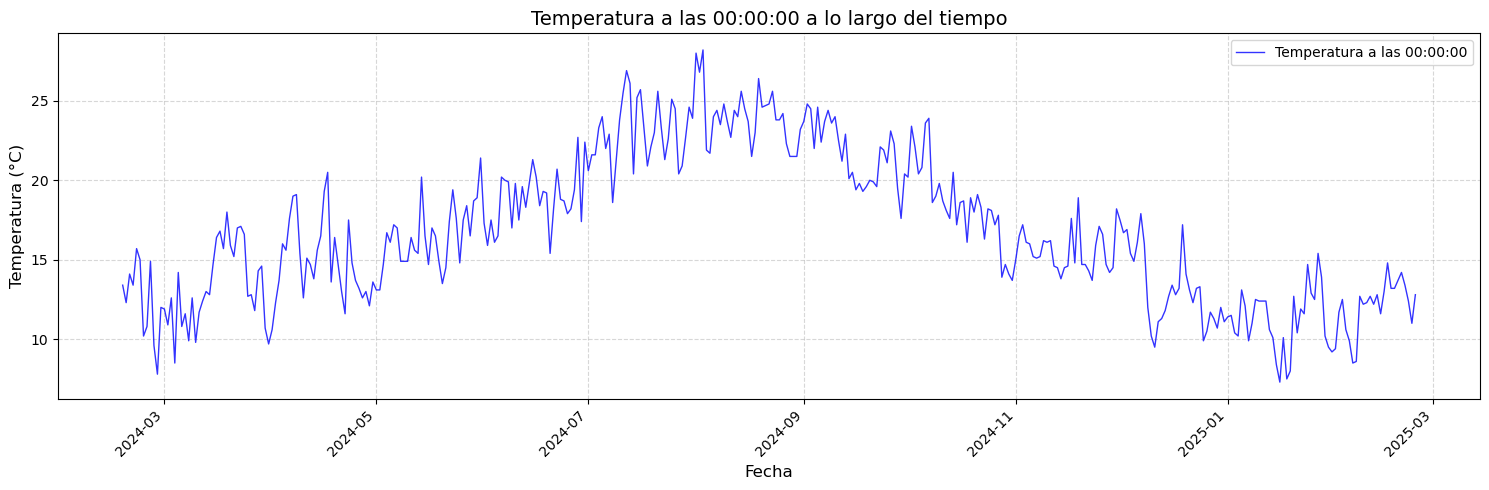

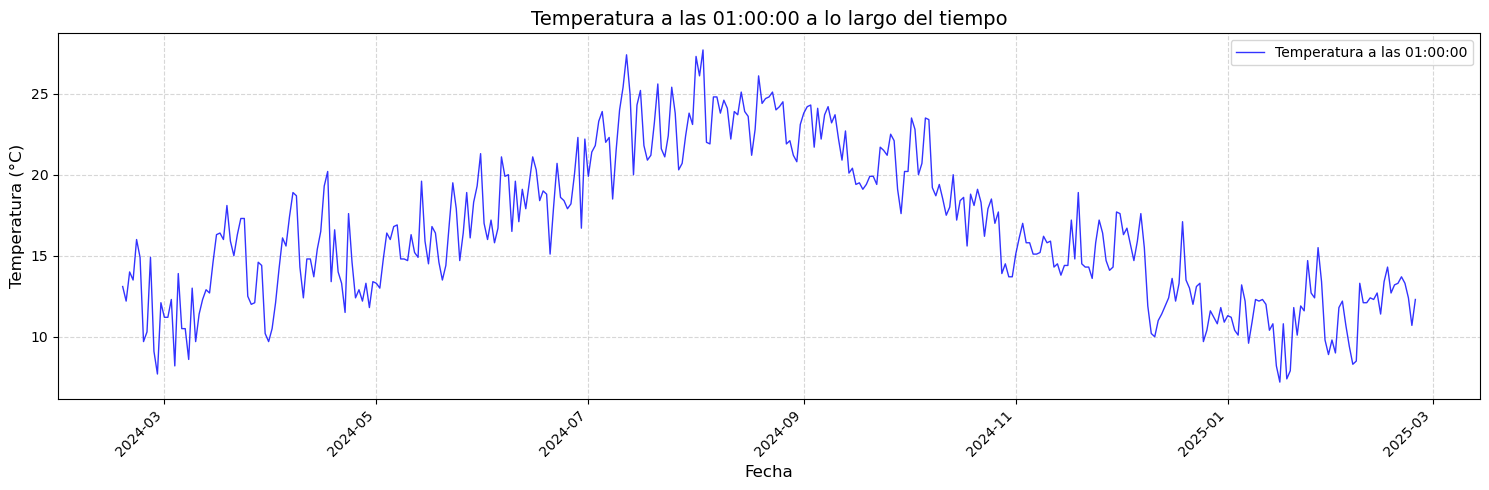

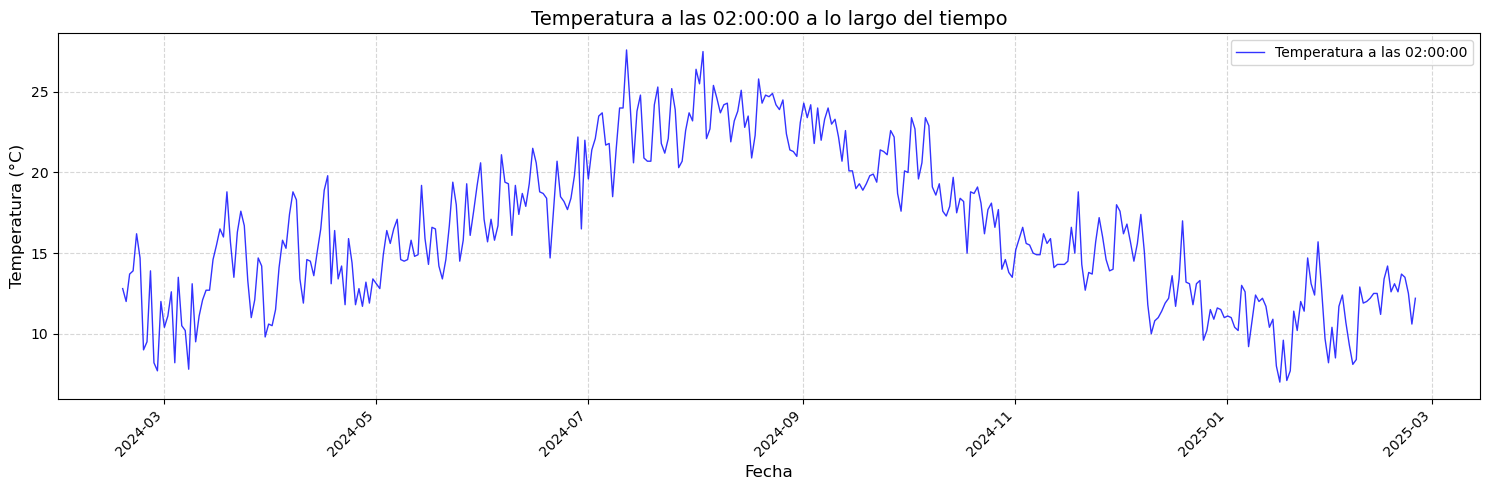

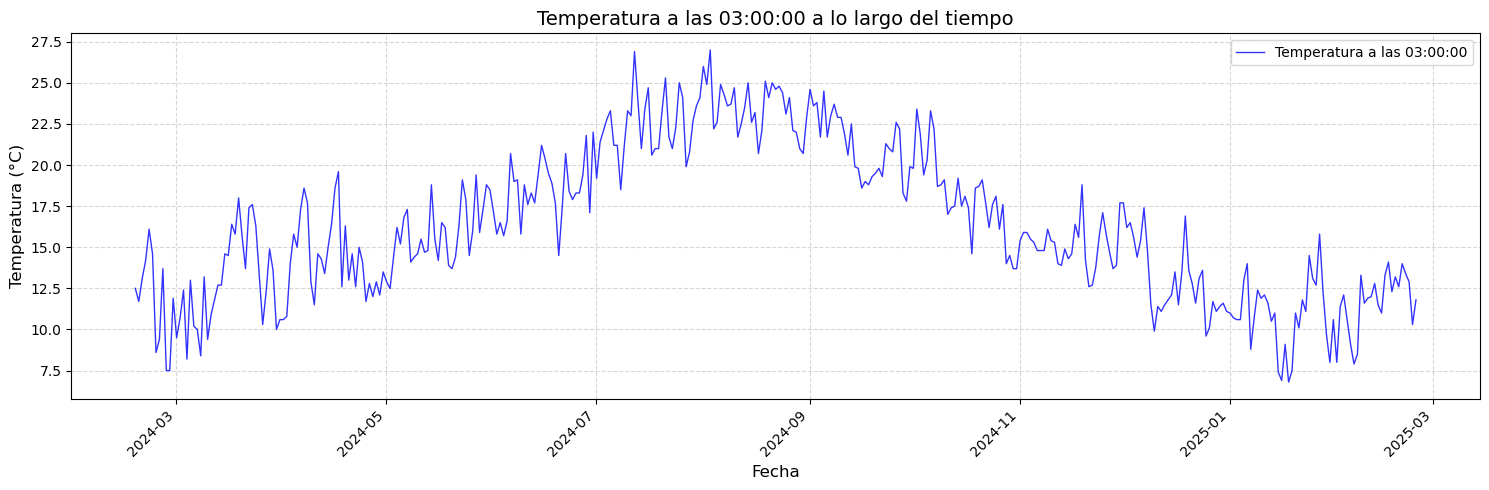

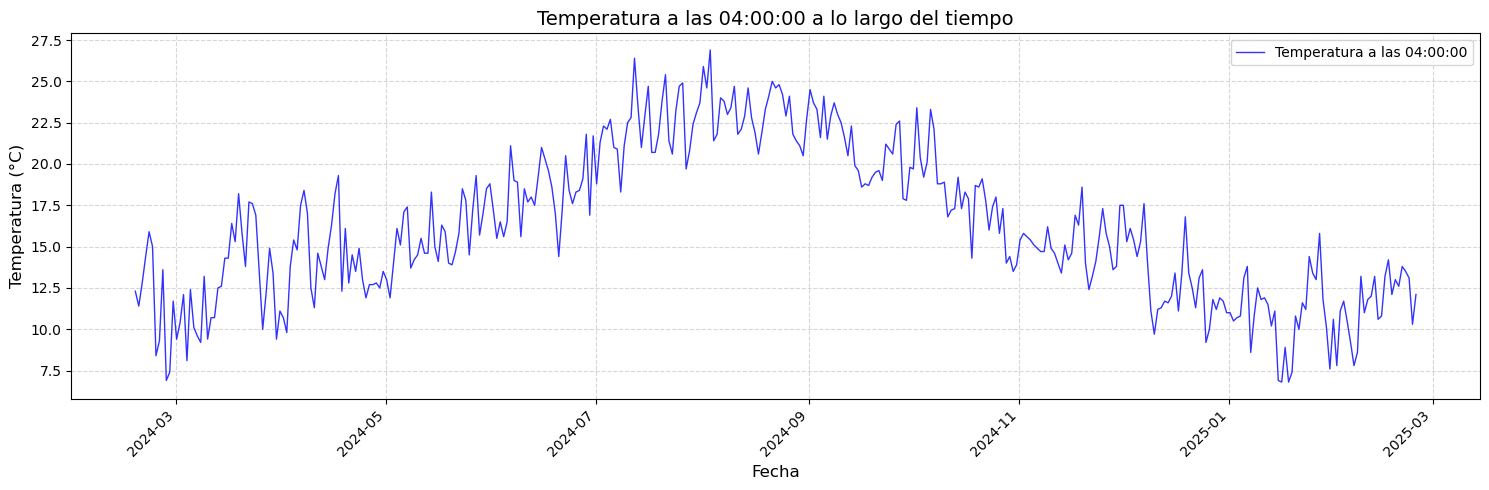

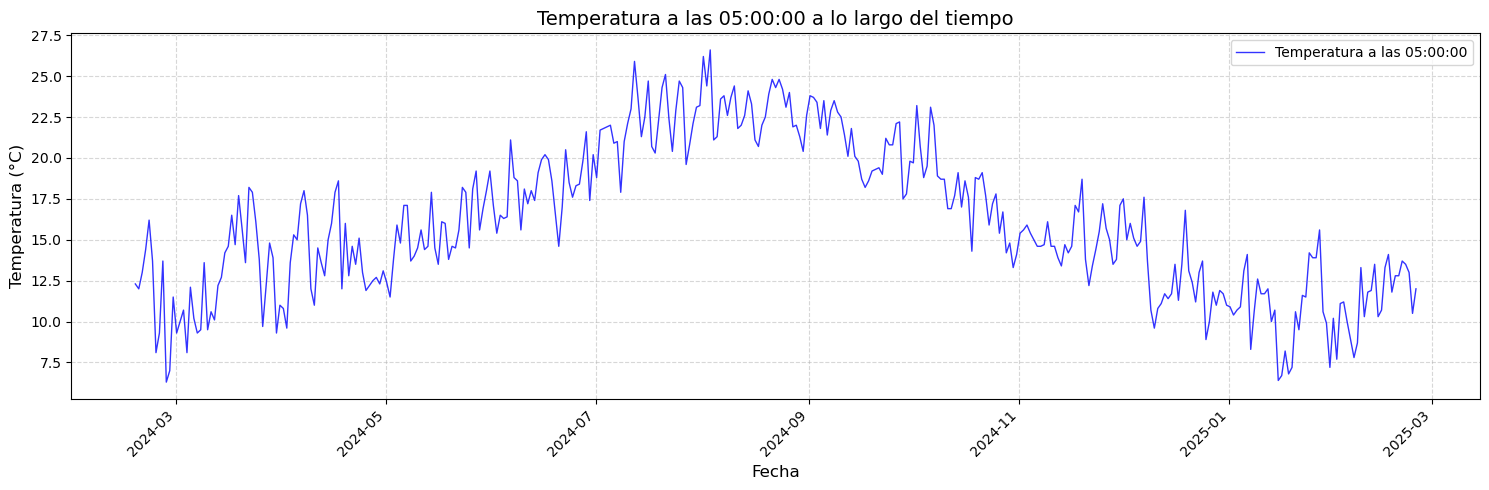

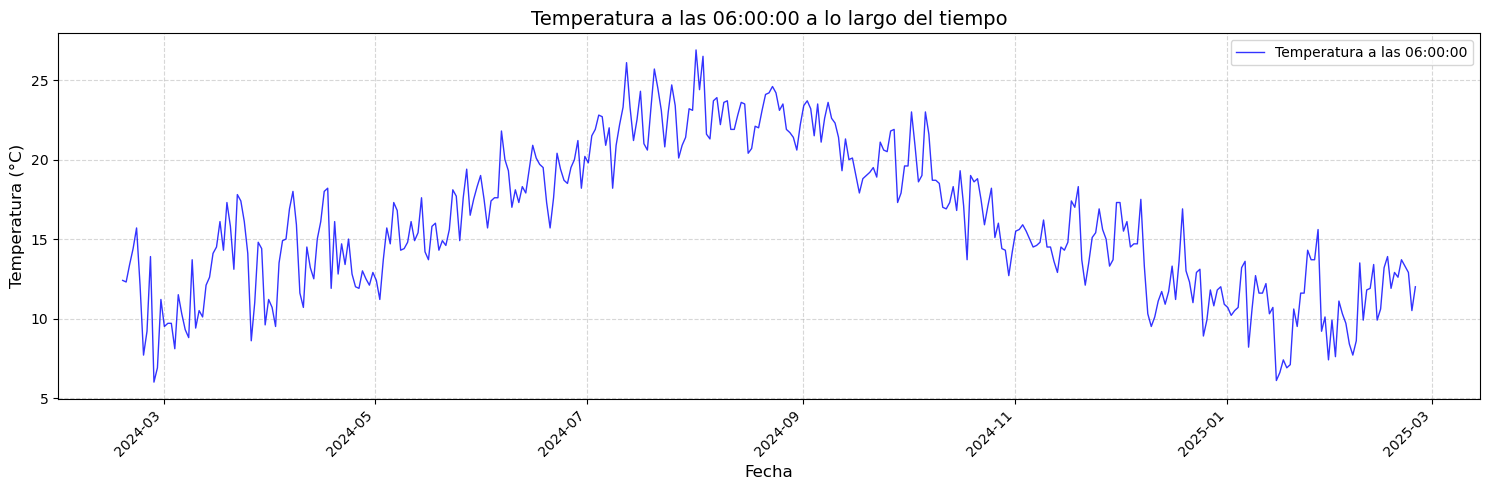

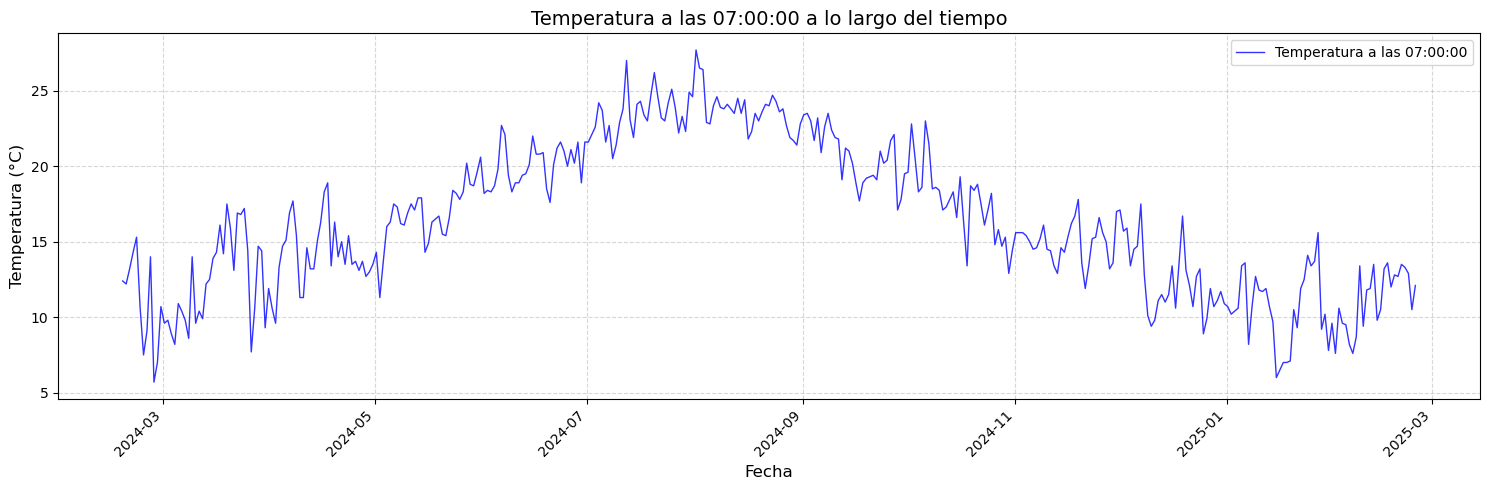

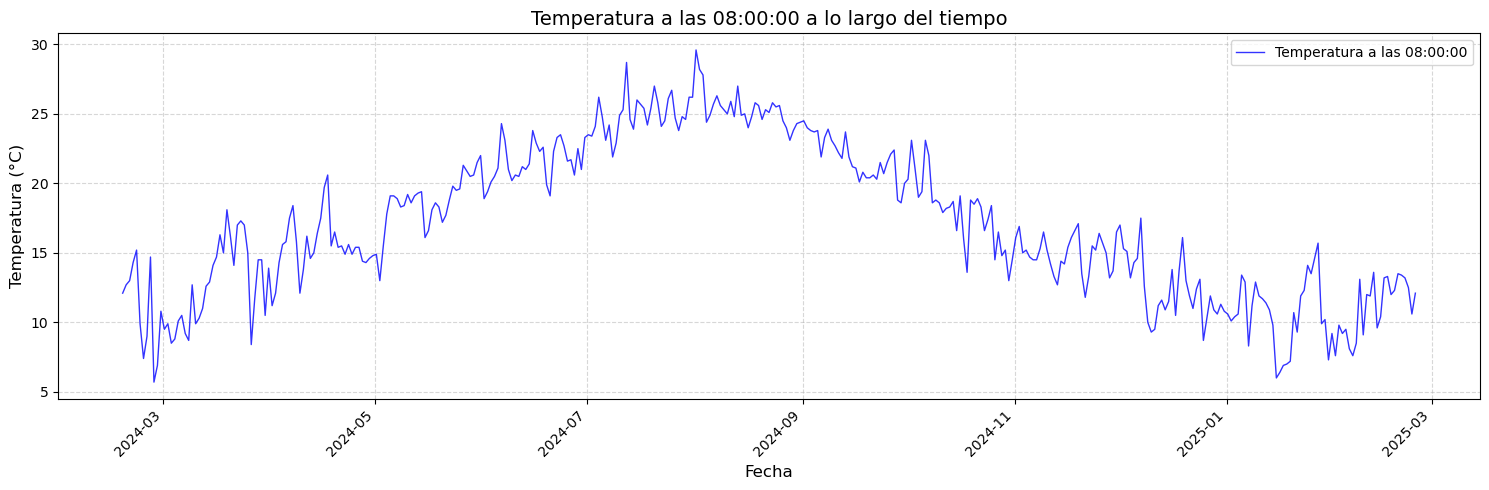

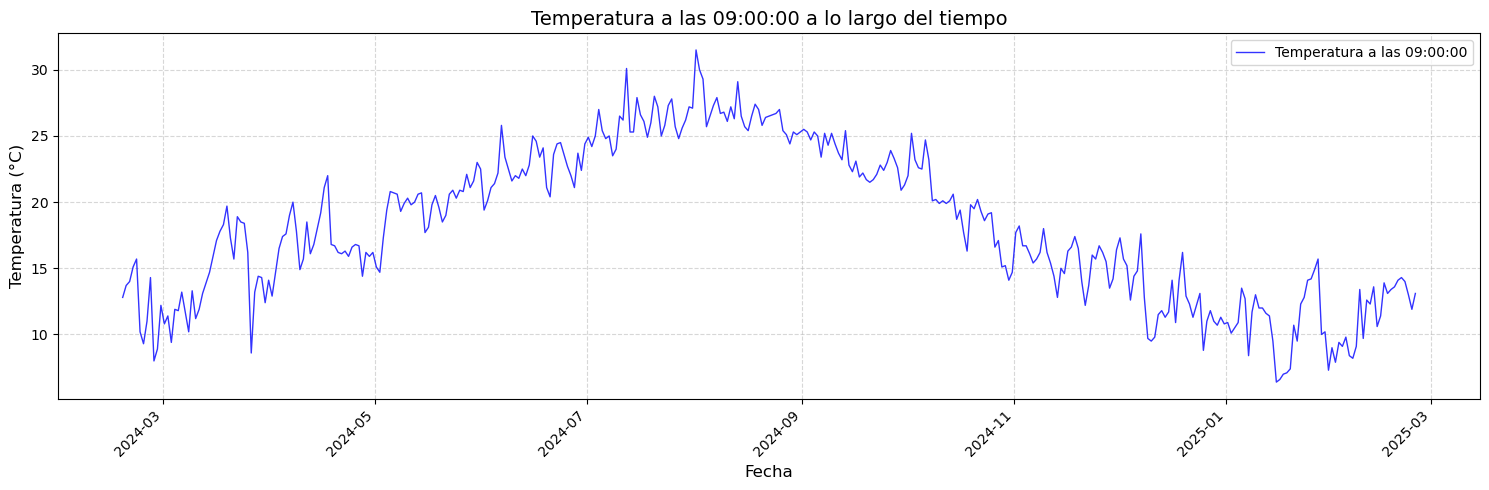

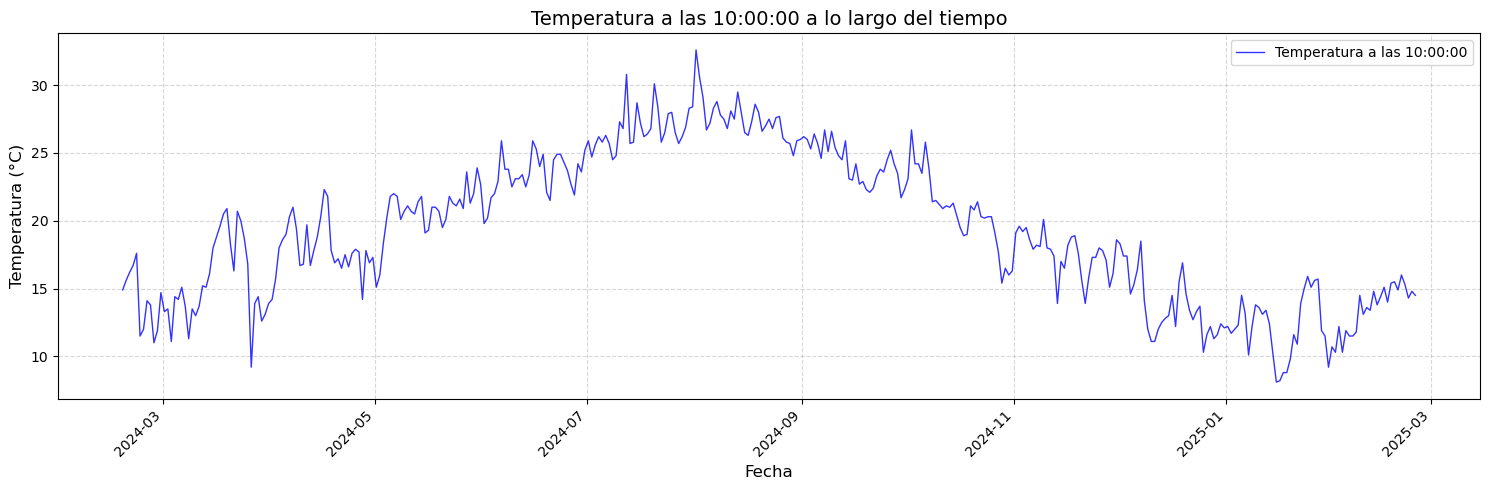

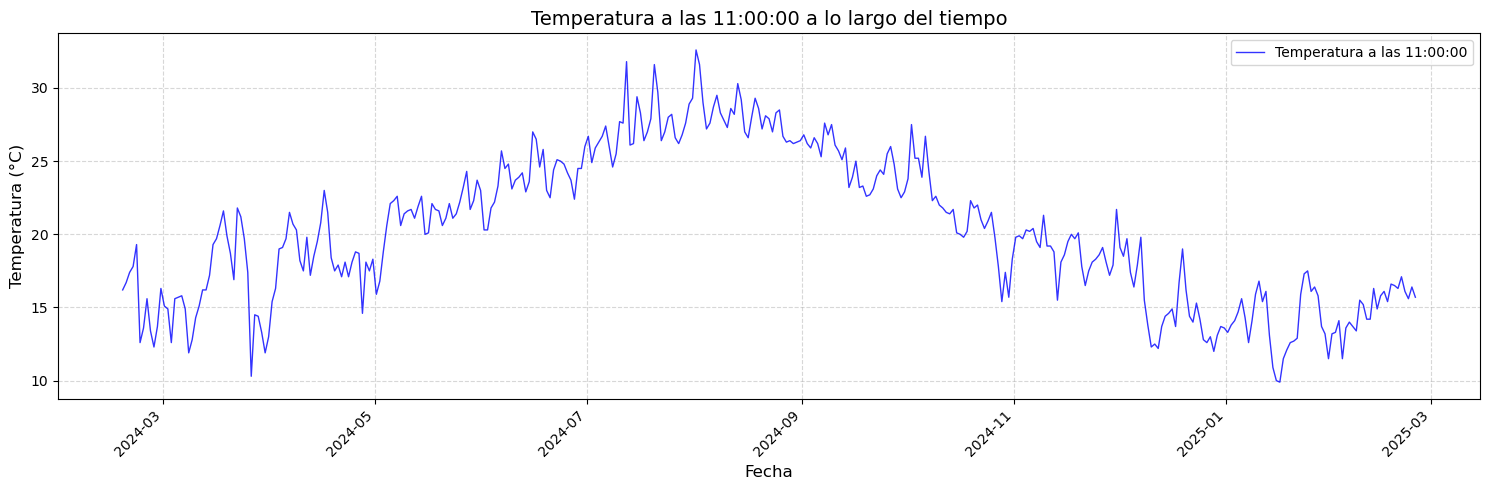

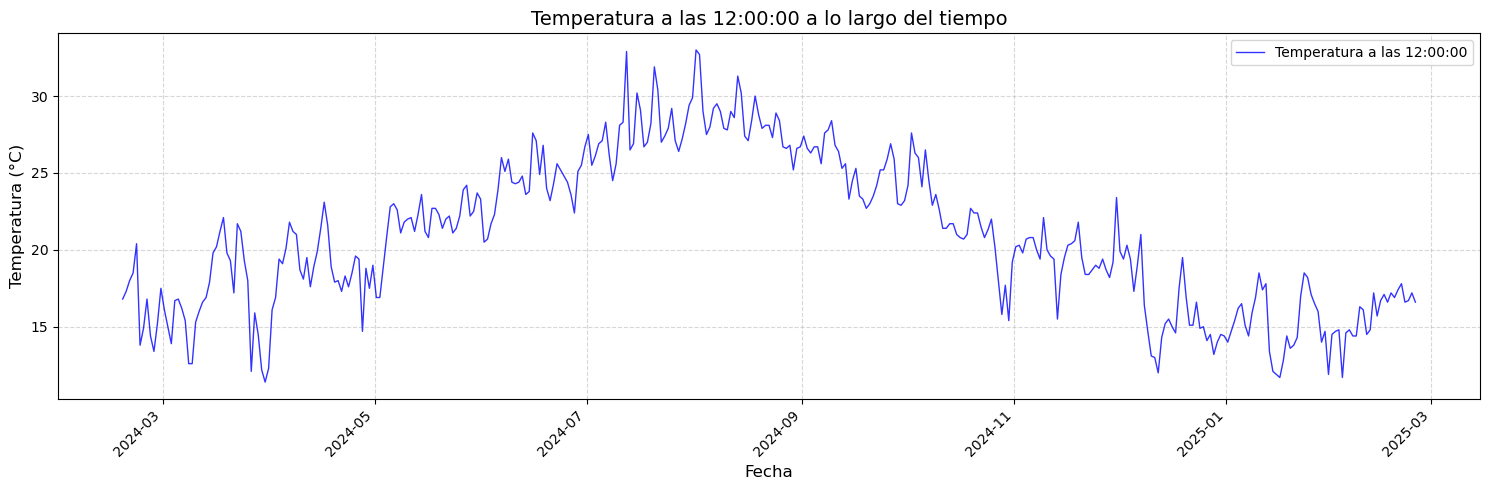

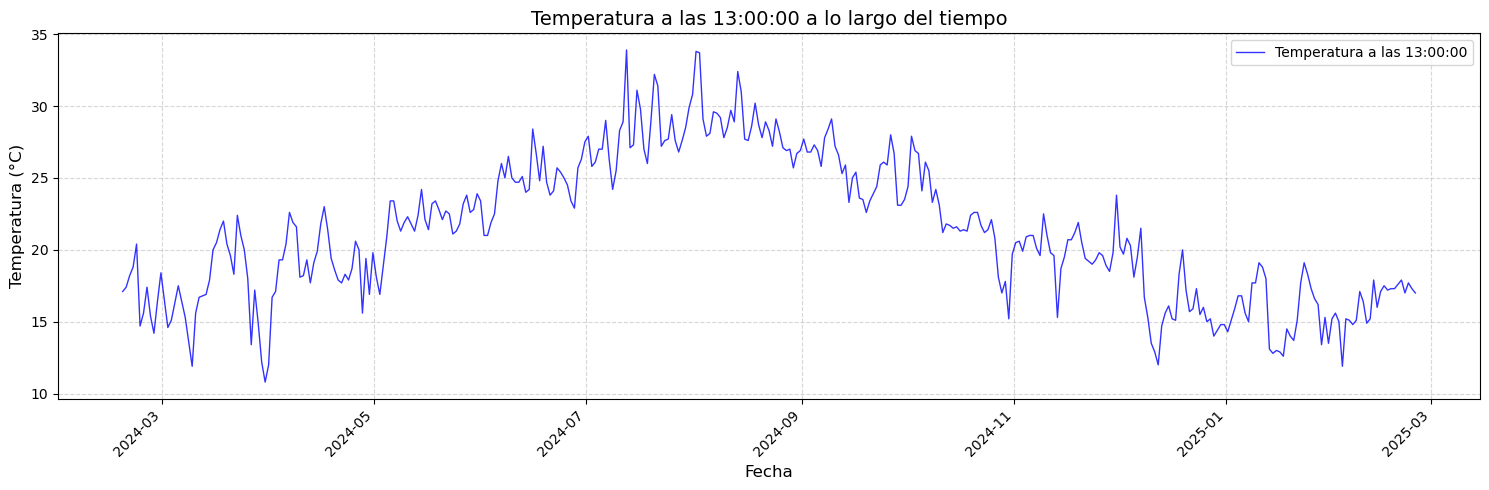

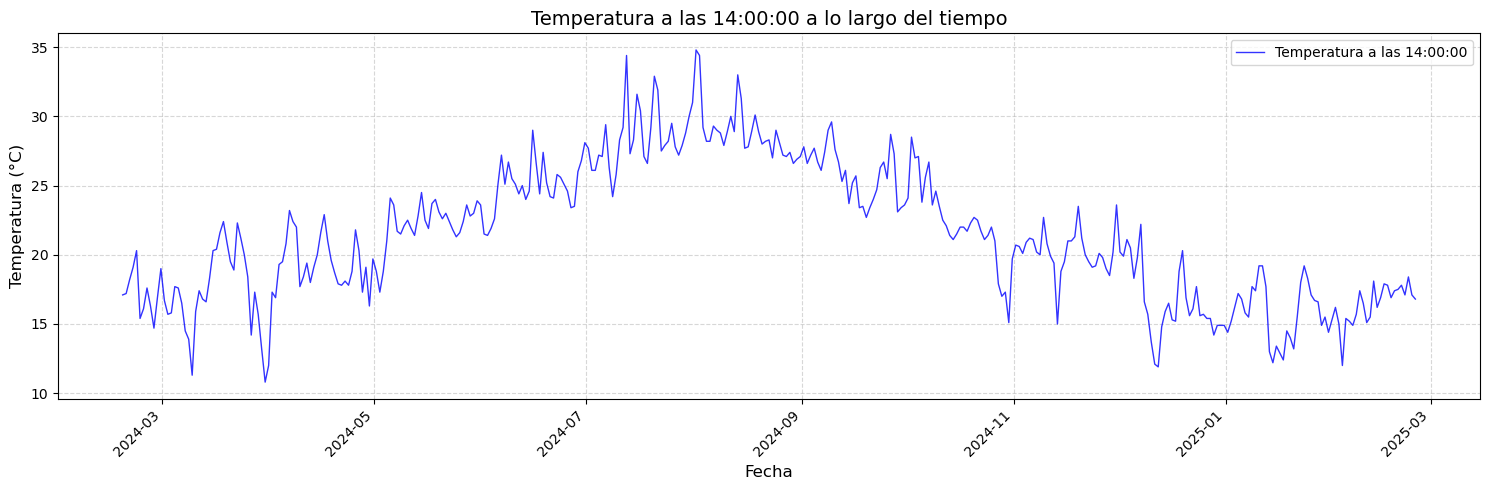

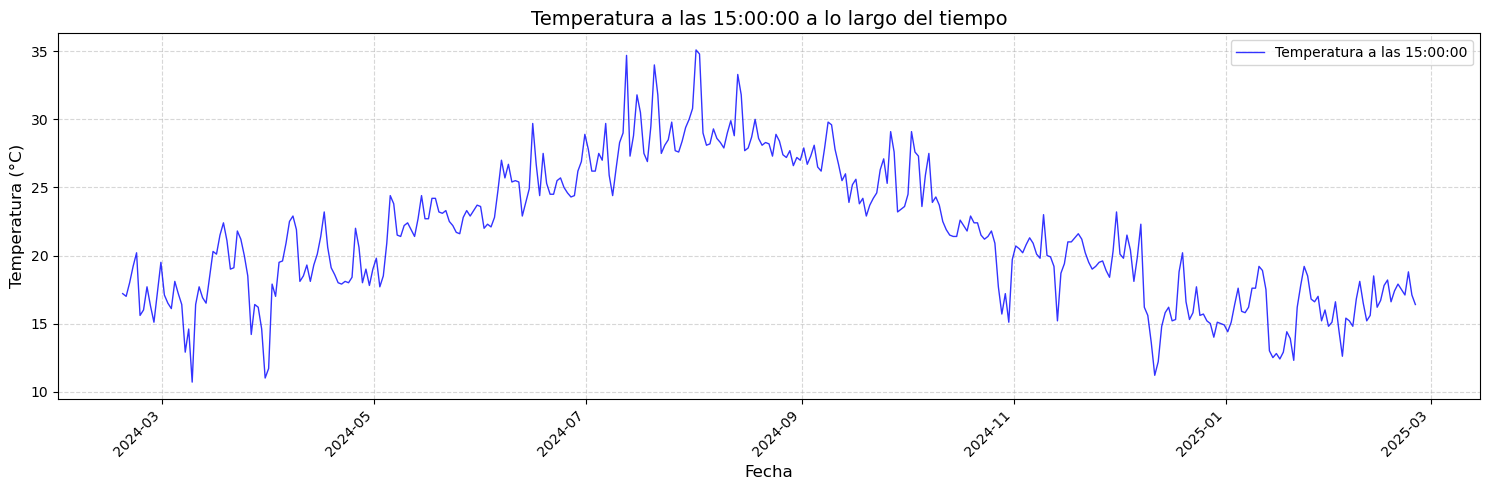

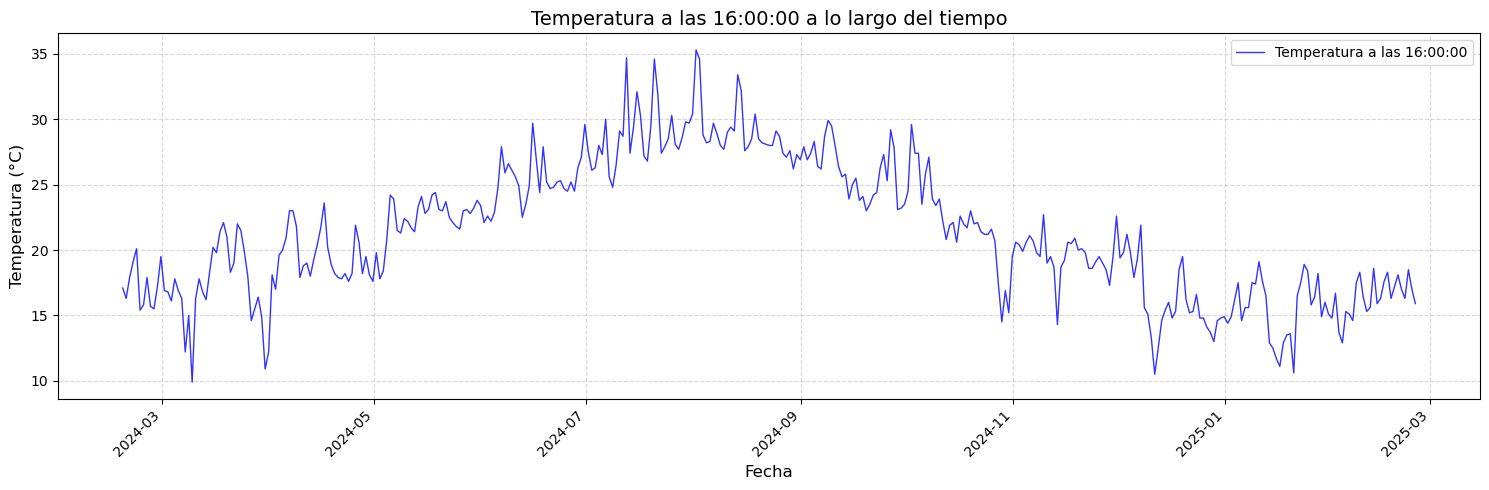

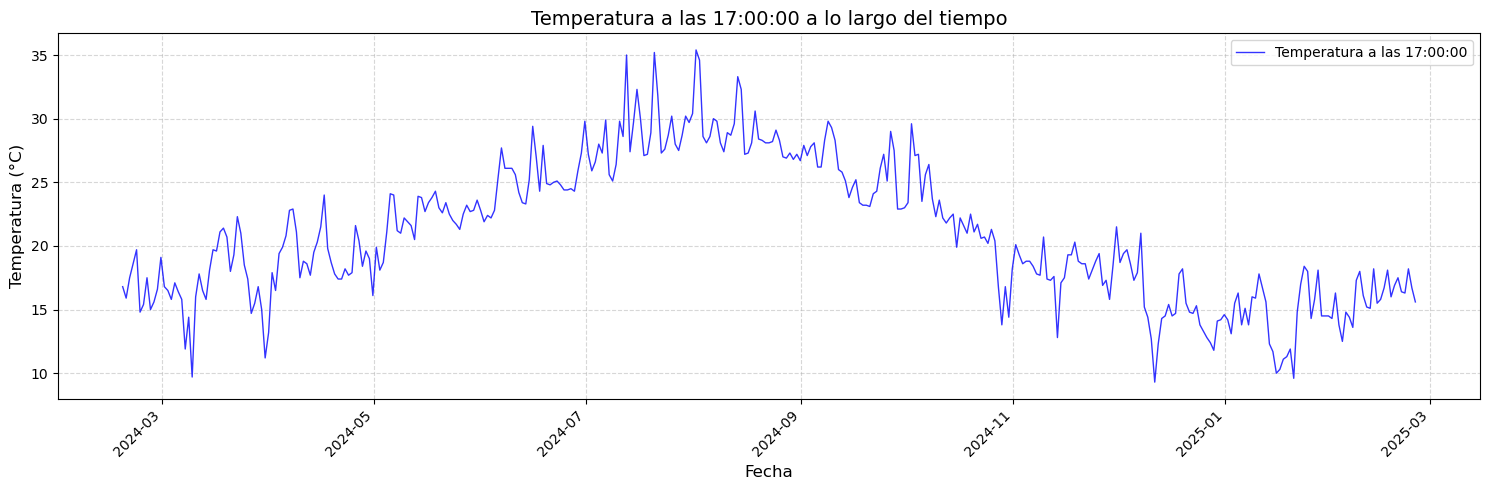

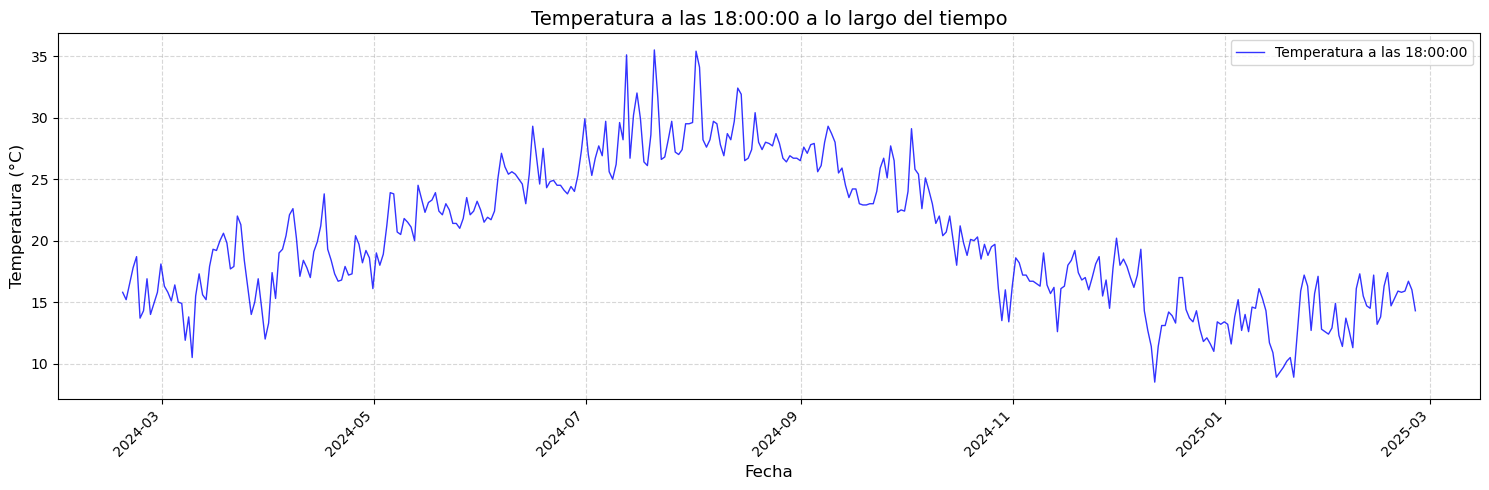

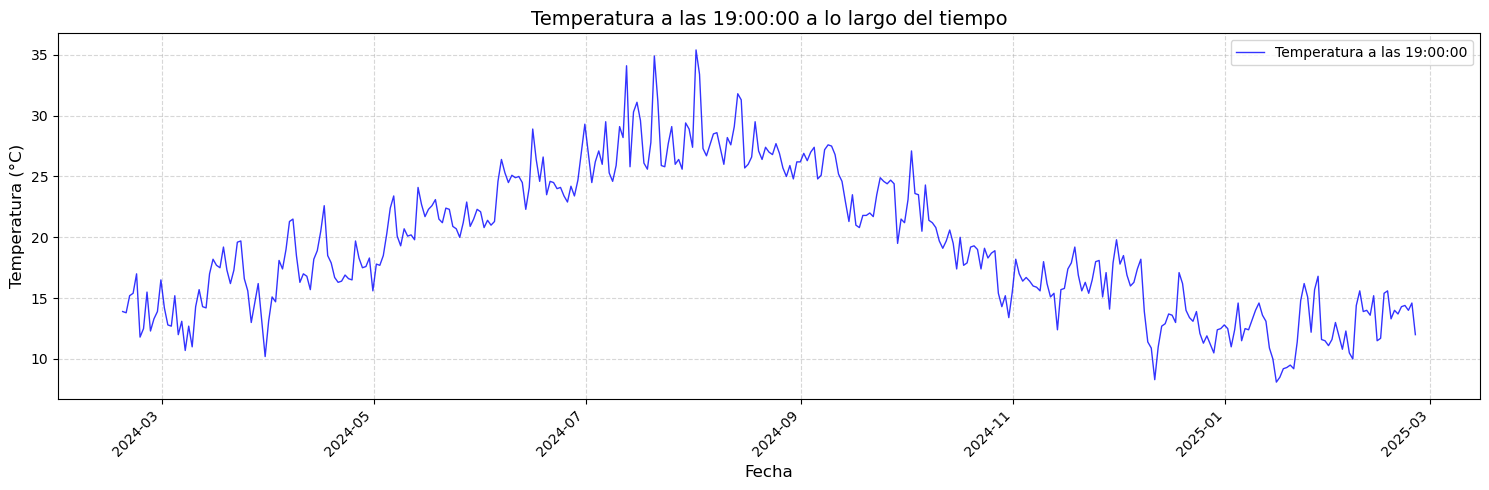

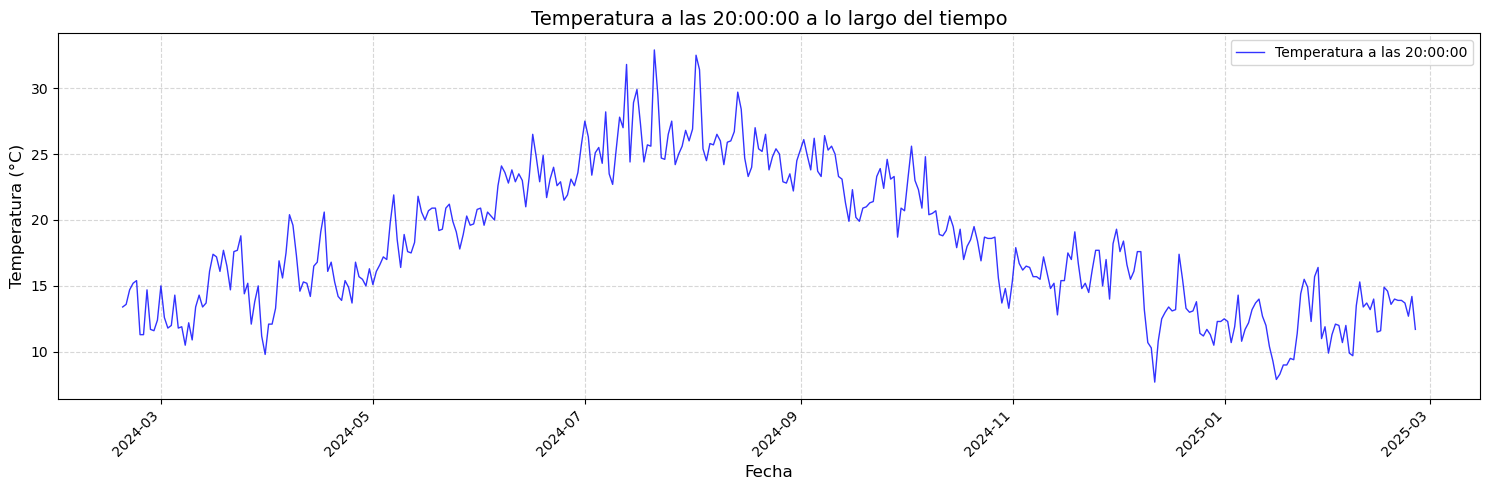

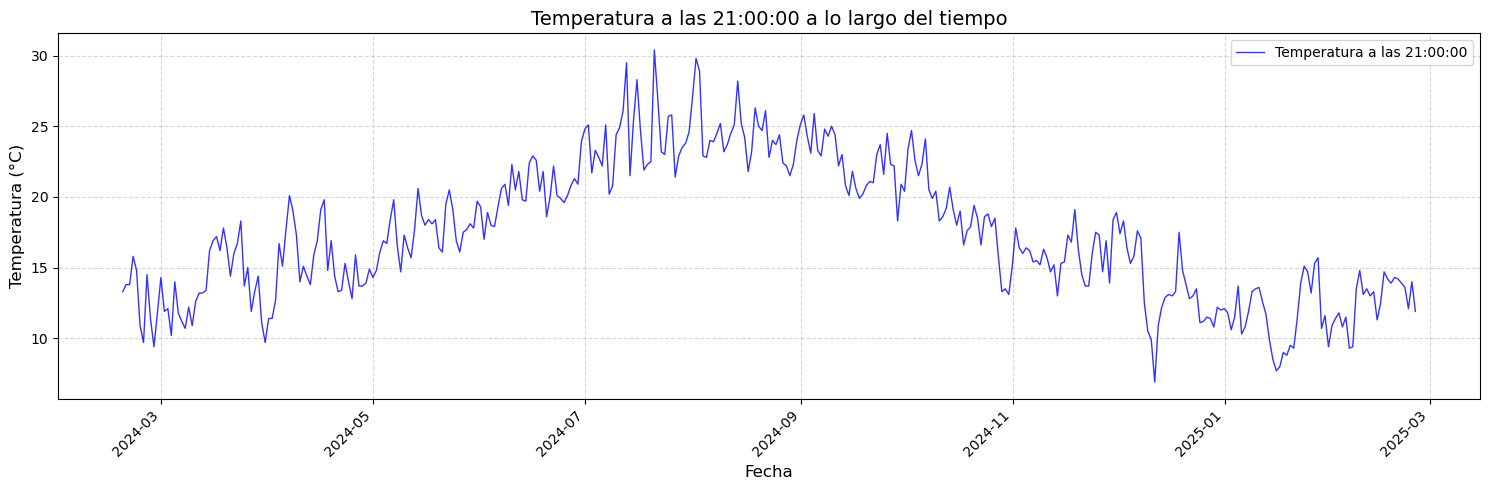

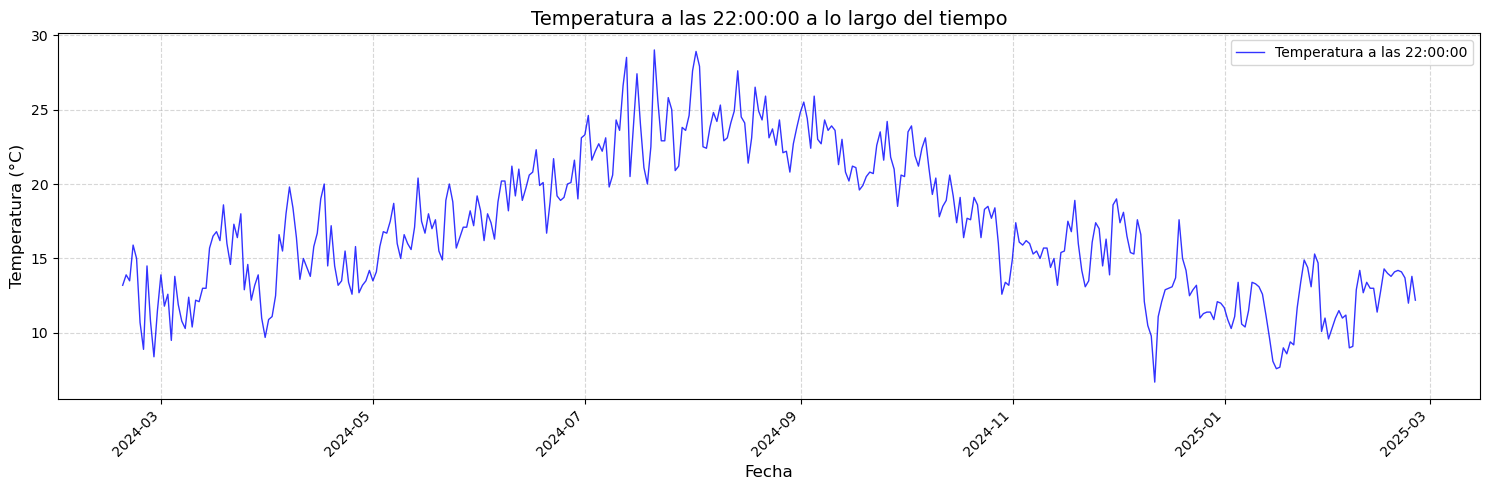

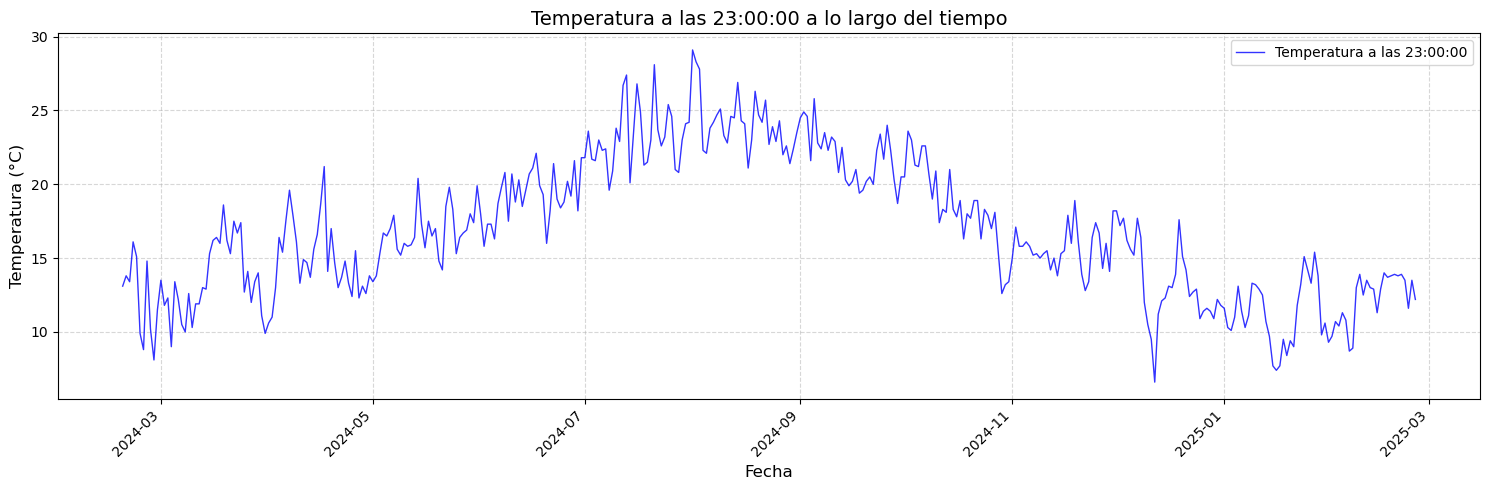

In [16]:
# Convertir el DataFrame de Spark a Pandas
df_pandas = df.toPandas()

# Convertir la columna 'Fecha' a tipo datetime si no lo está
df_pandas['Fecha'] = pd.to_datetime(df_pandas['Fecha'])

# Ordenar el DataFrame por fecha
df_pandas = df_pandas.sort_values(by='Fecha')

# Extraer la hora de la columna 'Fecha'
df_pandas['Hora'] = df_pandas['Fecha'].dt.hour

# Generar un gráfico para cada hora del día (desde 00:00:00 hasta 23:00:00)
for hora in range(24):  # Las horas van de 0 a 23
    # Filtrar los datos para la hora específica
    df_hora = df_pandas[df_pandas['Hora'] == hora]
    
    plt.figure(figsize=(15, 5))
    
    # Graficar la temperatura para la hora específica
    plt.plot(df_hora['Fecha'], df_hora['Temperatura_C'], linestyle='-', color='b', linewidth=1, alpha=0.8, label=f'Temperatura a las {hora:02d}:00:00')
    
    # Etiquetas y título
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Temperatura (°C)', fontsize=12)
    plt.title(f'Temperatura a las {hora:02d}:00:00 a lo largo del tiempo', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')

    # Mostrar el gráfico
    plt.tight_layout()  # Ajustar el layout para que no se solapen las etiquetas
    plt.show()

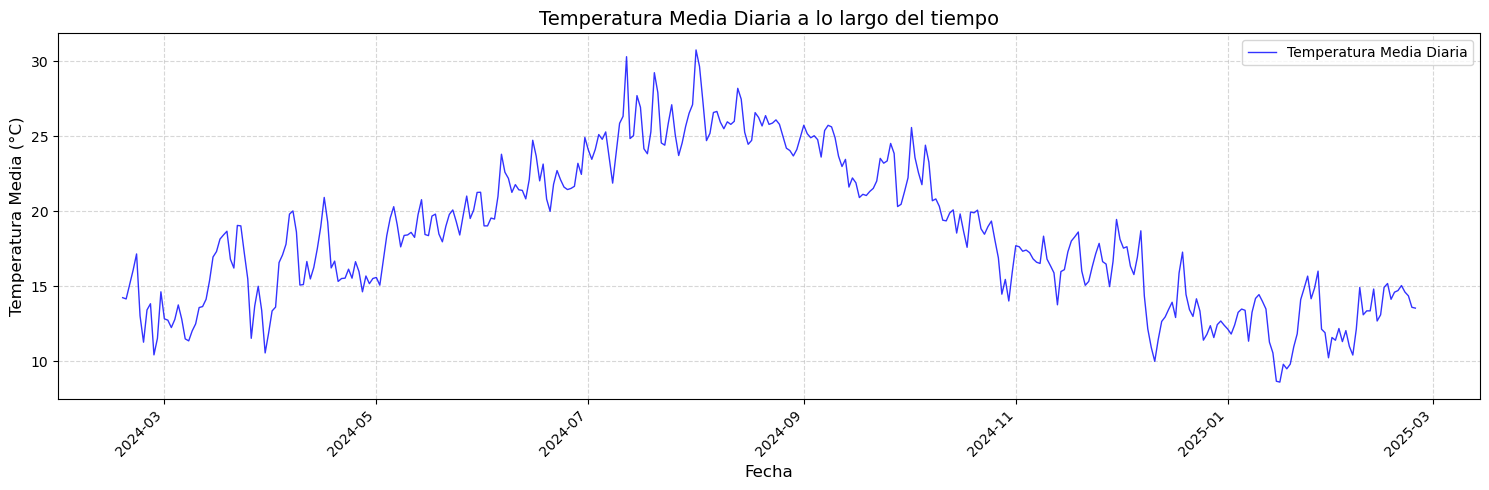

In [17]:
# Convertir el DataFrame de Spark a Pandas
df_pandas = df.toPandas()

# Convertir la columna 'Fecha' a tipo datetime si no lo está
df_pandas['Fecha'] = pd.to_datetime(df_pandas['Fecha'])

# Ordenar el DataFrame por fecha
df_pandas = df_pandas.sort_values(by='Fecha')

# Establecer la columna 'Fecha' como índice (necesario para usar resample)
df_pandas.set_index('Fecha', inplace=True)

# Calcular la temperatura media diaria
df_diario = df_pandas['Temperatura_C'].resample('D').mean()

# Graficar la temperatura media diaria
plt.figure(figsize=(15, 5))
plt.plot(df_diario.index, df_diario.values, linestyle='-', color='b', linewidth=1, alpha=0.8, label='Temperatura Media Diaria')

# Etiquetas y título
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura Media (°C)', fontsize=12)
plt.title('Temperatura Media Diaria a lo largo del tiempo', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el layout para que no se solapen las etiquetas
plt.show()

In [18]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+-----+-------------+-------------------+-------+----------+------+
|Fecha|Temperatura_C|Sensacion_termica_C|Humedad|Presion_mb|is_day|
+-----+-------------+-------------------+-------+----------+------+
|    0|            0|                  0|      0|         0|     0|
+-----+-------------+-------------------+-------+----------+------+



##### Guardar el dataset limpio de datos

In [19]:
# Guardar el DataFrame limpio en un nuevo archivo CSV (opcional)
ruta_guardado = "/home/jovyan/work/data/processed/df_marbella_hourly_cleaned.csv"
df.write.csv(ruta_guardado, header=True, mode="overwrite")

In [20]:
# Detener la sesión de Spark
spark.stop()